In [18]:
import cv2
import numpy as np
import os
from skimage import exposure, restoration
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from scipy.stats import kurtosis, skew

In [31]:
DATA_PATH = 'RetinalOCT_Dataset/RetinalOCT_Dataset'

def load_image(split, limit=50):
    images = []
    labels = []
    split_path = os.path.join(DATA_PATH, split)
    count = 0
    
    for i, folder in enumerate(os.listdir(split_path)):
        folder_path = os.path.join(split_path, folder)
        for file in os.listdir(folder_path):
            if count >= limit:
                break
            file_path = os.path.join(folder_path, file)
            img = cv2.imread(file_path)
            img = cv2.resize(img, (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
            images.append(img)
            labels.append(i)
            count += 1
    
    return np.array(images), np.array(labels)

train_img_raw, train_label = load_image('train')
val_img_raw, val_label = load_image('val')
test_img_raw, test_label = load_image('test')


In [20]:
def preprocess_oct(image):
    # 1. Denoising (Non-local Means)
    denoised = cv2.fastNlMeansDenoising(image, h=10)
    
    # 2. CLAHE untuk kontras lokal
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(denoised)
    
    # 3. Normalisasi ke [0, 1]
    norm = cv2.normalize(enhanced, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    return norm


In [21]:
train_img_pre = np.array([preprocess_oct(img) for img in train_img_raw])
val_img_pre   = np.array([preprocess_oct(img) for img in val_img_raw])
test_img_pre  = np.array([preprocess_oct(img) for img in test_img_raw])

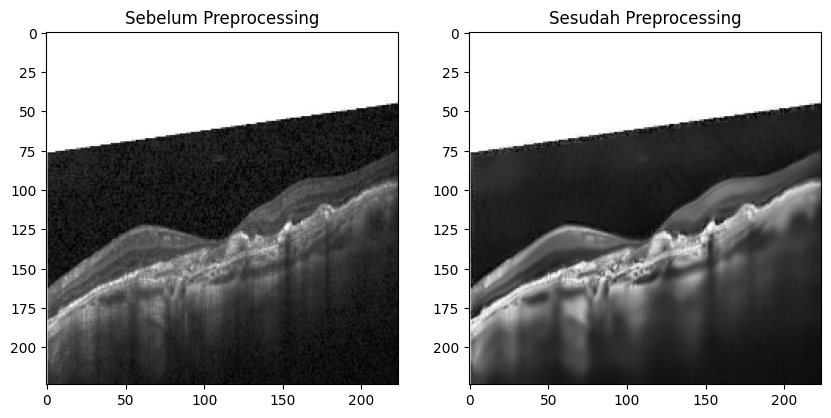

In [25]:
import matplotlib.pyplot as plt

idx = 49  # contoh index gambar
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(train_img_raw[idx], cmap='gray')
plt.title('Sebelum Preprocessing')

plt.subplot(1,2,2)
plt.imshow(train_img_pre[idx], cmap='gray')
plt.title('Sesudah Preprocessing')

plt.show()
